## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: **Дарханов Евгений Владленович**


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 26 февраля.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 99539626.61it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26345300.96it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31403039.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13725164.82it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

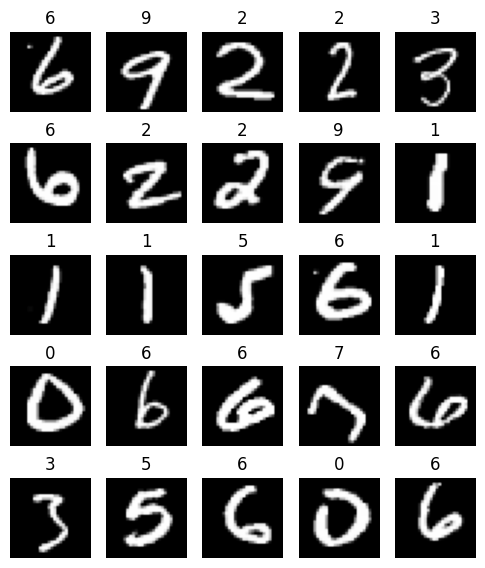

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [4]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2/(28*28))
init_layer(layer_2, 0, 2/500)

Соберем все вместе, используя ReLU в качестве функции активации:

In [33]:
network_HE = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_HE(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_HE.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0301469564437866
forward 0.04285633563995361
backward 0.03527668118476868
backward 0.0007544574327766895


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

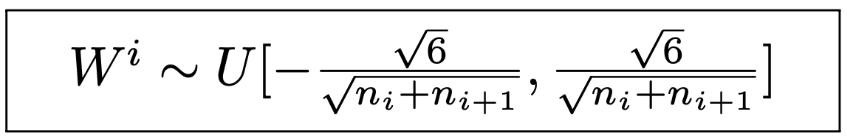

In [8]:
##### YOUR CODE HERE #####
def init_layer_xavier(layer, a, b):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

In [35]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_xavier(layer_1, -np.sqrt(6)/np.sqrt(28*28 + 500), np.sqrt(6)/np.sqrt(28*28 + 500))
init_layer_xavier(layer_2, -np.sqrt(6)/np.sqrt(500 + 10), np.sqrt(6)/np.sqrt(500 + 10))

In [36]:
network_XAVIER = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_XAVIER(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_XAVIER.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0301469564437866
forward 0.6574683785438538
backward 0.03527668118476868
backward 0.012450323440134525


**Вывод**:
- разница между дисперсиями $n_i$ и $n_{i + 1}$ при инициализации методом **Xavier** меньше, чем
при инициализации методом **He**
- значения порядков дисперсий $n_i$ и $n_{i + 1}$ при инициализации методом **Xavier** близки или одинаковы

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

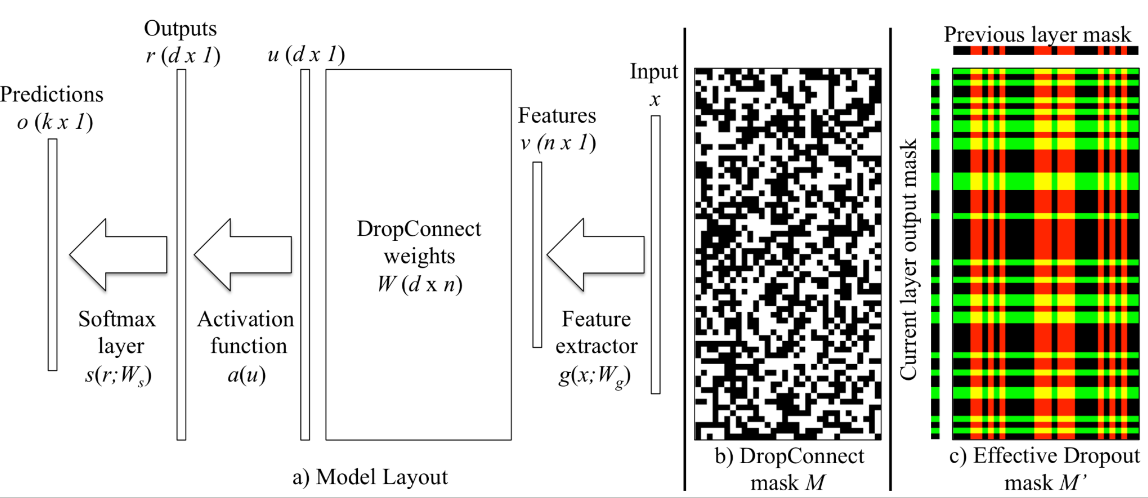

In [9]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(self.p)
        else:
            mask = torch.ones_like(self.linear.weight)

        mask.requires_grad = False
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)

        return output


class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Основа для сети, которую будем обучать:

In [10]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [12]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

layers_dropconnect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

Обучим получившуюся сеть:

In [13]:
def train(network, optimizer, loss_fn, n_epochs):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        network.train()
        train_loss = []

        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        history['train_loss'].append(np.mean(train_loss))

        network.eval()
        val_loss = []

        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            val_loss.append(loss.item())

        history['val_loss'].append(np.mean(val_loss))

        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(val_loss)))

    return history


In [64]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer = torch.optim.Adam(network_dropout.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_dropout = train(network_dropout, optimizer, loss_fn, 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309910
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.078198
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.654543
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.458957
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.323640
Test Epoch: 0	Loss: 0.289310
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.259715
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.216790
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.333880
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.258860
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.191841
Test Epoch: 1	Loss: 0.184170
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.232198
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.246086
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.183914
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.315404
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.155710
Test Epoch: 2	Loss: 0.146041
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.149460
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.198276
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.149587
Train Epoch: 3 [38400/60000 (64%)

In [67]:
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_dropconnect = train(network_dropconnect, optimizer, loss_fn, 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310919
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.443397
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.002337
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.796188
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.897359
Test Epoch: 0	Loss: 1.412324
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.618024
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.594290
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.539498
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.429218
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.340621
Test Epoch: 1	Loss: 0.917957
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.645422
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.335556
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.304063
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.306960
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.369814
Test Epoch: 2	Loss: 0.756207
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.207096
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.305585
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.391415
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


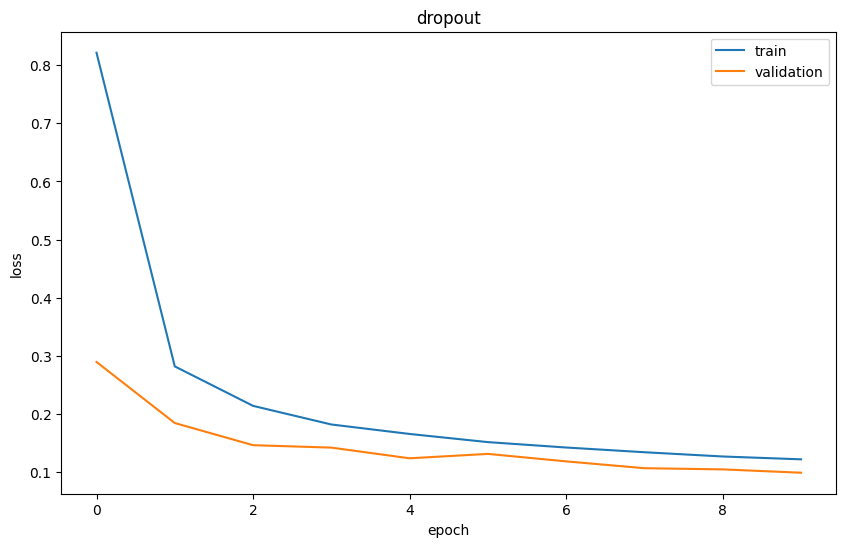

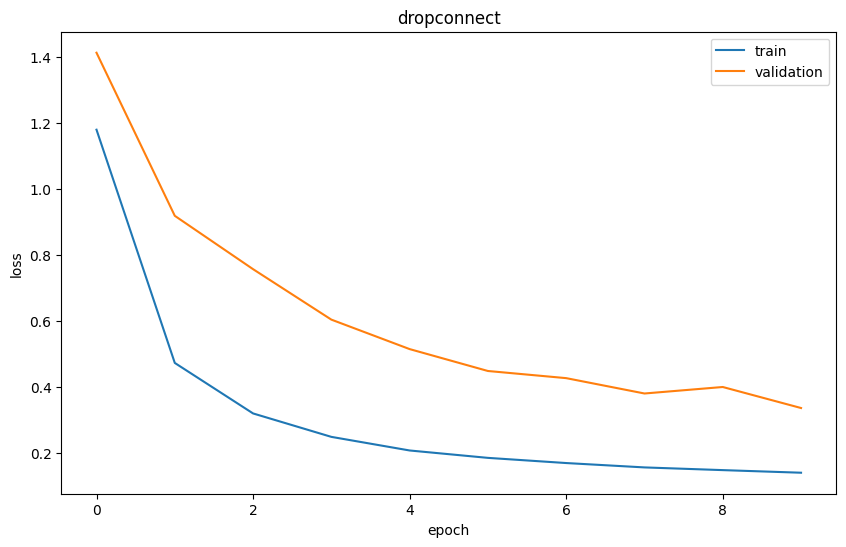

In [71]:
##### YOUR CODE HERE #####
for history, name in [(history_dropout, 'dropout'), (history_dropconnect, 'dropconnect')]:
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='validation')

    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.legend()

**Вывод**: dropout сходится быстрее, чем dropconnect. Значения лосса лучше у dropout

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

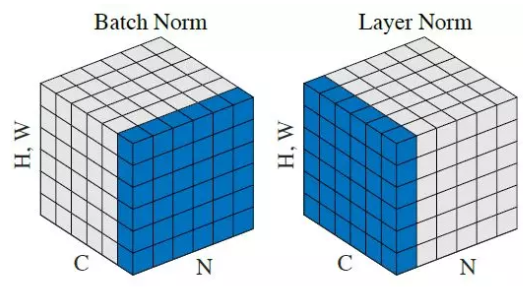

In [14]:
for batch_idx, (images_train, labels_train) in enumerate(train_loader):
    break

In [29]:
images_train.shape

torch.Size([128, 1, 28, 28])

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [40]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dims, epsilon=1e-8):
        super().__init__()
        self.dims = dims
        self.gamma = nn.Parameter(torch.ones(dims), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(dims), requires_grad=True)
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        output = self.gamma * (x - mean) / (std + self.epsilon) + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [41]:
##### YOUR CODE HERE #####
layers_batchnorm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

layers_layernorm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 10)
]

In [24]:
network_batchnorm = TestNetwork(nn.Sequential(*layers_batchnorm))
optimizer = torch.optim.Adam(network_batchnorm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_batchnorm = train(network_batchnorm, optimizer, loss_fn, 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.473560
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.218701
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.211250
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.088053
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.078636
Test Epoch: 0	Loss: 0.109045
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.068160
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.126018
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061738
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.062508
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.061530
Test Epoch: 1	Loss: 0.071496
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034178
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080459
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.058075
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.075733
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.026892
Test Epoch: 2	Loss: 0.060462
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.064303
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.073729
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.076394
Train Epoch: 3 [38400/60000 (64%)

In [42]:
network_layernorm = TestNetwork(nn.Sequential(*layers_layernorm))
optimizer = torch.optim.Adam(network_layernorm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_layernorm = train(network_layernorm, optimizer, loss_fn, 10)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.480962
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.367336
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.279079
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.158145
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.150688
Test Epoch: 0	Loss: 0.139980
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.090583
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.066535
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.093820
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.074748
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.047867
Test Epoch: 1	Loss: 0.091650
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.082291
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.083082
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.058653
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.106797
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.144273
Test Epoch: 2	Loss: 0.098064
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034464
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.073443
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.086807
Train Epoch: 3 [38400/60000 (64%)

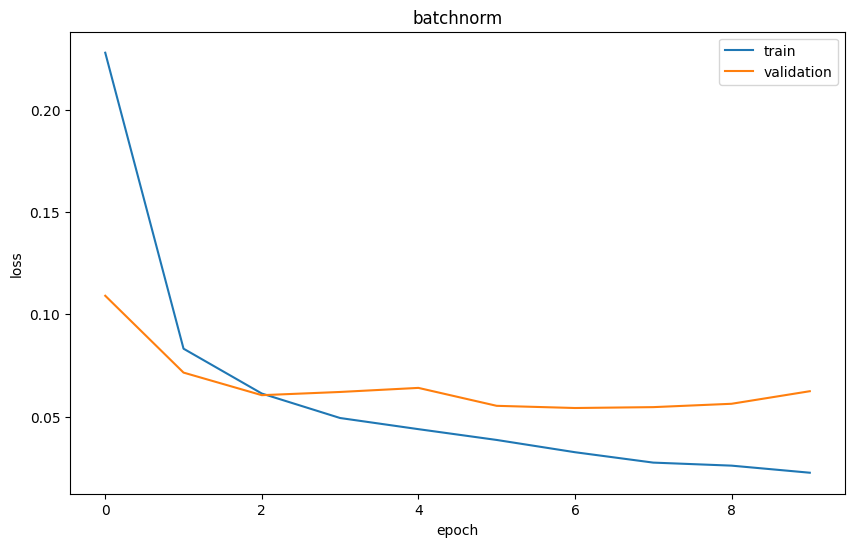

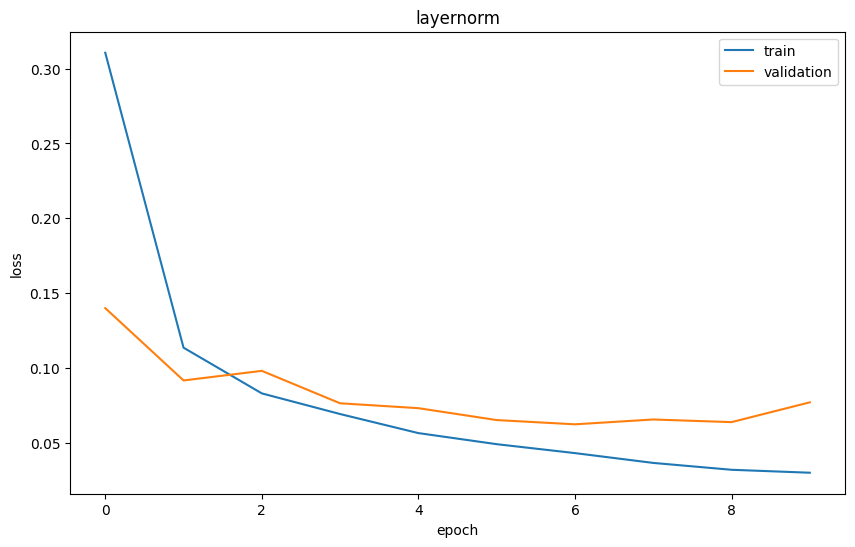

In [43]:
##### YOUR CODE HERE #####
for history, name in [(history_batchnorm, 'batchnorm'), (history_layernorm, 'layernorm')]:
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='validation')

    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.legend()

**Вывод**: по форме графиков результаты применения **batchnorm** и **layernorm** отличаются несильно, однако у **batchnorm** значения ошибок меньше